In [3]:
import pathlib

path=str(pathlib.Path().resolve())+"\\Faces"

In [37]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

class ImageDataset(tf.keras.utils.Sequence):
    def __init__(self, dir, transform=None):
        self.data_dir = dir
        self.transform = transform
        self.train = self.__get_dataset_tensor__(os.path.join(dir, "Train"))
        self.test = self.__get_dataset_tensor__(os.path.join(dir, "Test"))
        self.val = self.__get_dataset_tensor__(os.path.join(dir, "Validation"))
        self.x = self.train.concatenate(self.test).concatenate(self.val)
        self.y = ['Fake','Real']

    def __len__(self):
        return len(self.images)

    def __get_dataset_tensor__(self, dir):
        dataset = tf.keras.utils.image_dataset_from_directory(
            dir,
            seed=42,
            image_size=(128, 128))
        if self.transform:
            dataset = dataset.map(self.transform)
        return dataset


    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)

        return image

    def transform_np(self, img, labels, type, needsArray=True):
        threadL = []
        images = []
        lLabels = []

        with ThreadPoolExecutor() as executor:
            chunk_size = len(img) // 100
            chunks = [img[i:i + chunk_size] for i in range(0, len(img), chunk_size)]
            labelChunk = [labels[i:i + chunk_size] for i in range(0, len(img), chunk_size)]
            for i, l in zip(chunks, labelChunk):
                threadL.append(executor.submit(self.thread_array, i, l, type, needsArray))
            for index, i in enumerate(threadL):
                print(index)
                values = i.result()
                images.append(values[0])
                lLabels.append(values[1])
        return np.concatenate(images), np.concatenate(lLabels)

    def thread_array(self, array, labels, type, needsArray):
        return np.array([cv.cvtColor(cv.resize(cv.imread(x), dsize=(128, 128), interpolation=cv.INTER_AREA) if needsArray else x, type) for x in array]), labels


In [38]:
dataset = ImageDataset(path)

Found 140002 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_5950_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[190335,128,128,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:ConcatV2] name: concat

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset.y=encoder.fit_transform(dataset.y)

In [20]:
dataset.y

array([0, 1], dtype=int64)

TypeError: '_ConcatenateDataset' object is not subscriptable

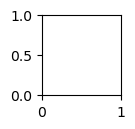

In [22]:
from matplotlib import pyplot as plt


class_names = np.unique(dataset.y)

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(dataset.X[index].numpy(), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[dataset.y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
dataset.images[0].shape

(128, 128)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test , y_train_full, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train, X_val , y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.2,random_state=42)

<BarContainer object of 2 artists>

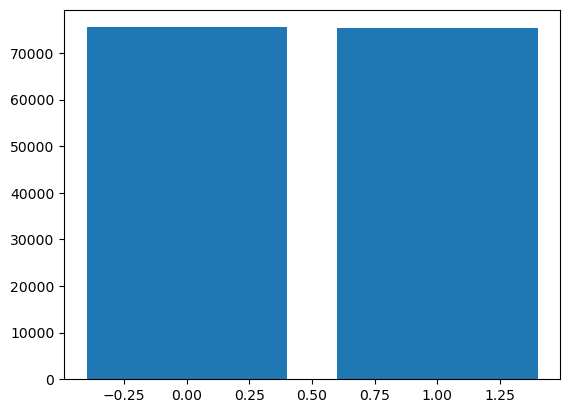

In [ ]:
values=np.unique(y, return_counts=True)
plt.bar(np.unique(encoder.inverse_transform(y)),values[1])

# Model Processing

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
model = models.Sequential()

# Va hacer 32 Kernels que serán 3X3 es decir
# Recogera de cada 3 pixeles el central para la nueva imagen 
# Podríamos indicar los Strides (1,1) que son las casillas que avanza
# Le decimos que sea 28 x 28 y que tenga un canal
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(layers.Conv2D(32,(3,3),activation="relu"))

# Se va reduciendo la imagen por lo que podemos aumentar el número de filtros, donde la imagen se nos va a la mitad
model.add(layers.MaxPooling2D((2,2)))

# Lo normal es aumentar el número de filtros en la imagen
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))

# Aplana la capa actual
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.Flatten())

model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(len(np.unique(y_train_full)),activation="sigmoid"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                     

In [ ]:
model.compile(loss="binary_crossentropy",  optimizer=keras.optimizers.Adam(learning_rate=0.001),   metrics=["accuracy"])

In [ ]:

import sys

#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
#tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
#tf.config.get_visible_devices()


#cpus = tf.config.experimental.list_physical_devices('CPU')
#print(cpus)
#tf.config.set_visible_devices([], 'GPU')  # hide the GPU
#tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
#tf.config.get_visible_devices()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)


history = model.fit(X_train,y_train,epochs=sys.maxsize,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

Epoch 1/9223372036854775807


ValueError: in user code:

    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

NameError: name 'history' is not defined

In [ ]:
model.evaluate(X_test,y_test)

25/25 [==============================] - 2s 60ms/step - loss: 2.6403 - accuracy: 0.3938


[2.6402697563171387, 0.39375001192092896]

In [ ]:
y_pred = model.predict(X_test).round(2)

25/25 [==============================] - 2s 65ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)
np.array(class_names)[y_pred]

array(['sad', 'happy', 'happy', 'happy', 'sad', 'happy', 'happy', 'angry',
       'sad', 'happy', 'sad', 'relaxed', 'sad', 'sad', 'sad', 'happy',
       'happy', 'relaxed', 'happy', 'relaxed', 'relaxed', 'relaxed',
       'angry', 'sad', 'happy', 'angry', 'happy', 'happy', 'happy',
       'happy', 'sad', 'sad', 'sad', 'sad', 'happy', 'relaxed', 'sad',
       'sad', 'angry', 'happy', 'happy', 'angry', 'sad', 'sad', 'sad',
       'angry', 'happy', 'relaxed', 'angry', 'sad', 'sad', 'relaxed',
       'happy', 'sad', 'relaxed', 'relaxed', 'sad', 'happy', 'relaxed',
       'sad', 'sad', 'happy', 'sad', 'angry', 'sad', 'angry', 'sad',
       'happy', 'happy', 'sad', 'angry', 'relaxed', 'happy', 'angry',
       'relaxed', 'sad', 'angry', 'angry', 'angry', 'happy', 'happy',
       'angry', 'relaxed', 'happy', 'happy', 'relaxed', 'happy',
       'relaxed', 'happy', 'happy', 'sad', 'happy', 'relaxed', 'happy',
       'sad', 'happy', 'sad', 'angry', 'happy', 'happy', 'happy', 'angry',
       'happ

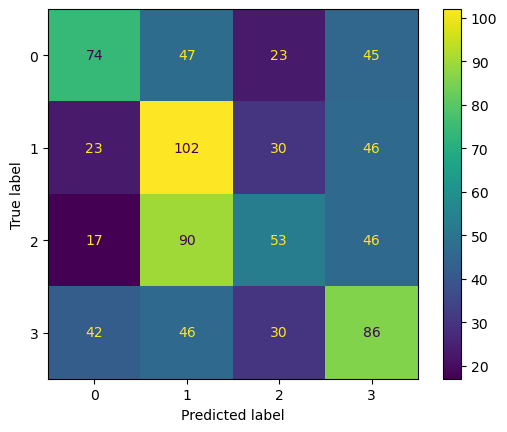

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()